# CatBoost Tutorial

<img alt="CatBoost Logo" src="catboost_logo.png" align="left">

Here's a link to the docs - https://catboost.ai/docs/.

## Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, average_precision_score, balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from catboost import CatBoostClassifier, Pool, cv

Set plot parameters

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Custom Functions

In [3]:
def my_errors(model, X_test, y_test, skl_api = False):
    if skl_api:
        probs = model.predict_proba(X_test)
    else:
        probs = model.predict(X_test)
    preds = np.asarray([np.argmax(line) for line in probs])
    print("Average Precision Score: {}".format(average_precision_score(y_test, preds)))
    print("Balanced Accuracy Score: {}".format(balanced_accuracy_score(y_test, preds)))
    return probs, preds

In [4]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', ax=ax, square = True, cmap = 'PuBu', cbar_kws = {'label':'Percentage'}, vmin = 0, vmax = 100) # Change cm_perc to cm if coloring is by %
    
    #!!UNCOMMENT if your mpl is not updated (if cm_analysis output is not square)
#     # fix for mpl bug that cuts off top/bottom of seaborn viz
#     b, t = plt.ylim() # discover the values for bottom and top
#     b += 0.5 # Add 0.5 to the bottom
#     t -= 0.5 # Subtract 0.5 from the top
#     plt.ylim(b, t) # update the ylim(bottom, top) values
    
    plt.show()

## Heart Disease Data

We'll be using the Heart Disease Data Set from the UCI Machine Learning Repository, accessed through Kaggle (https://www.kaggle.com/ronitf/heart-disease-uci). It has a lot of categorical features, so we'll be able to make good use of CatBoost. The downside is there are only 303 samples.

Let's load the data and look at the columns and the head

In [5]:
folder = r"C:\Users\ponglao\OneDrive - savvysherpa.com\Dev Group\heartdisease"
data = pd.read_csv(folder + '\\heart.csv')
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [6]:
data.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

Here's a description of the columns:
1. `age` (int)
1. `sex` (cat)<br>
0 = femaile, 1 = male
1. `cp` (cat) - chest pain type<br>
0 = asymptomatic, 1 = atypical angina, 2 = non-anginal pain, 3 = typical angina
1. `trestbps` (int) - resting blood pressure
1. `chol` (int) - blood serum cholesterol
1. `fbs` (cat) - if fasting blood sugar is > 120 mg/dl<br>
0 = False, 1 = True
1. `restecg` (cat) - resting electrocardiographic results<br>
0 = probable/definite left ventricular hypertrophy, 1 = normal, 2 = having ST-T wave abnormality
1. `thalach` (int) - maximum heart rate achieved
1. `exang` (cat) - exercise induced angina<br>
0 = no, 1 = yes
1. `oldpeak` (float) - ST depression (a finding on an electrocardiogram) induced by exercise relative to rest
1. `slope`(cat) - slope of the peak exercise ST segment<br>
0 = downsloping, 1 = flat, 2 = upsloping
1. `ca` (int) - number of major vessels colored by fluoroscopy
1. `thal` (cat) - blood flow measurement using thallium<br>
0 = null, 1 = fixed defect, 2 = normal, 3 = reversible defect
1. `target` (cat) - **indicator of NO heart disease**<br>
0 = disease, 1 = no disease

The following links helped me understand the columns better:
- https://www.kaggle.com/ronitf/heart-disease-uci/discussion/105877
- https://www.kaggle.com/ronitf/heart-disease-uci/discussion/92838

Let's check the distribution of `target`

In [7]:
df1 = data.target.value_counts().rename('Count')
df2 = (data.target.value_counts(normalize = True)*100).rename('Percent')
pd.concat([df1,df2], axis = 1).style.format({'Percent':'{:.2f}%'})

Separate the data into X (features) and y (class/target)

In [8]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

Split the data into train and test sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1010, stratify = y)

**\!\! IMPORTANT**<br>
We need to define the categorical columns of our dataset. Note that we **don't have to do any encoding** for these cat columns. We simply need to make an array/list of the *numeric indices* of the cat columns. <br>
The cell below does just that.

In [10]:
cat_features = ['sex','cp','fbs','restecg','exang','slope', 'thal'] #list down the cat column names
cat_features = [i for i,item in enumerate(X.columns) if item in cat_features] #get numeric indices based on column order in X
cat_features

[1, 2, 5, 6, 8, 10, 12]

## CatBoost Modeling

### Basics

The model object is `CatBoostClassifier` <br>
Below, we create a Classifier object with default parameters (except random state, which we specify as 1010)

In [11]:
model = CatBoostClassifier(random_state=1010)

Fitting uses sklearn syntax.
Here are some important functions. <br>
1. **`.fit`** <br>
> The first two args are your X (features) and y (targets) <br>
> Notice that we can set `plot = True` in the model to plot the loss function during training. It's a neat feature! <br>
> Also notice the arg `cat_features` - the *numeric indices* of the categorical features in X. Since we have categorical features, we specify this when we fit. <br>

1. **`.predict`** and **`.predict_proba`** <br>
> These output the predicted classes and probabilities, respectively

Notice in the cell below how Logloss is plotted (in real time) as your model is fitting. The **plots are interactive**. <br>
Also notice that there is a **time estimate** for how long the model will run, also another great feature!

In [12]:
model.fit(X_train, y_train, cat_features = cat_features, plot = True)
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.005621
0:	learn: 0.6902282	total: 84.9ms	remaining: 1m 24s
1:	learn: 0.6856966	total: 112ms	remaining: 56s
2:	learn: 0.6817450	total: 131ms	remaining: 43.7s
3:	learn: 0.6786744	total: 150ms	remaining: 37.4s
4:	learn: 0.6748284	total: 171ms	remaining: 34.1s
5:	learn: 0.6713394	total: 188ms	remaining: 31.1s
6:	learn: 0.6671853	total: 197ms	remaining: 28s
7:	learn: 0.6635964	total: 210ms	remaining: 26.1s
8:	learn: 0.6604403	total: 217ms	remaining: 23.9s
9:	learn: 0.6572662	total: 224ms	remaining: 22.2s
10:	learn: 0.6554608	total: 226ms	remaining: 20.3s
11:	learn: 0.6517637	total: 242ms	remaining: 19.9s
12:	learn: 0.6482602	total: 249ms	remaining: 18.9s
13:	learn: 0.6449387	total: 259ms	remaining: 18.2s
14:	learn: 0.6414415	total: 269ms	remaining: 17.7s
15:	learn: 0.6384453	total: 283ms	remaining: 17.4s
16:	learn: 0.6354971	total: 290ms	remaining: 16.8s
17:	learn: 0.6316828	total: 301ms	remaining: 16.4s
18:	learn: 0.6291004	total: 323ms	remaining: 16.7s
19:	learn: 0.

170:	learn: 0.3800785	total: 2.1s	remaining: 10.2s
171:	learn: 0.3789871	total: 2.11s	remaining: 10.2s
172:	learn: 0.3779926	total: 2.12s	remaining: 10.1s
173:	learn: 0.3769378	total: 2.14s	remaining: 10.2s
174:	learn: 0.3765625	total: 2.15s	remaining: 10.1s
175:	learn: 0.3760216	total: 2.15s	remaining: 10.1s
176:	learn: 0.3750140	total: 2.17s	remaining: 10.1s
177:	learn: 0.3741901	total: 2.17s	remaining: 10s
178:	learn: 0.3730202	total: 2.19s	remaining: 10.1s
179:	learn: 0.3720234	total: 2.19s	remaining: 10s
180:	learn: 0.3707705	total: 2.21s	remaining: 9.98s
181:	learn: 0.3697448	total: 2.22s	remaining: 9.97s
182:	learn: 0.3689860	total: 2.23s	remaining: 9.97s
183:	learn: 0.3681647	total: 2.24s	remaining: 9.95s
184:	learn: 0.3672041	total: 2.25s	remaining: 9.93s
185:	learn: 0.3663164	total: 2.27s	remaining: 9.94s
186:	learn: 0.3654393	total: 2.27s	remaining: 9.89s
187:	learn: 0.3646792	total: 2.3s	remaining: 9.92s
188:	learn: 0.3638443	total: 2.31s	remaining: 9.9s
189:	learn: 0.36309

338:	learn: 0.2807228	total: 4.27s	remaining: 8.32s
339:	learn: 0.2801074	total: 4.28s	remaining: 8.3s
340:	learn: 0.2798956	total: 4.3s	remaining: 8.3s
341:	learn: 0.2794624	total: 4.32s	remaining: 8.31s
342:	learn: 0.2790911	total: 4.34s	remaining: 8.32s
343:	learn: 0.2785090	total: 4.36s	remaining: 8.32s
344:	learn: 0.2781091	total: 4.39s	remaining: 8.33s
345:	learn: 0.2775586	total: 4.41s	remaining: 8.34s
346:	learn: 0.2770685	total: 4.42s	remaining: 8.32s
347:	learn: 0.2768328	total: 4.44s	remaining: 8.32s
348:	learn: 0.2765647	total: 4.46s	remaining: 8.32s
349:	learn: 0.2759995	total: 4.47s	remaining: 8.3s
350:	learn: 0.2756193	total: 4.48s	remaining: 8.28s
351:	learn: 0.2753724	total: 4.48s	remaining: 8.26s
352:	learn: 0.2751354	total: 4.5s	remaining: 8.24s
353:	learn: 0.2748207	total: 4.51s	remaining: 8.23s
354:	learn: 0.2743713	total: 4.53s	remaining: 8.22s
355:	learn: 0.2741580	total: 4.55s	remaining: 8.24s
356:	learn: 0.2737134	total: 4.58s	remaining: 8.24s
357:	learn: 0.273

500:	learn: 0.2324177	total: 6.41s	remaining: 6.39s
501:	learn: 0.2321012	total: 6.44s	remaining: 6.39s
502:	learn: 0.2320220	total: 6.44s	remaining: 6.37s
503:	learn: 0.2318971	total: 6.47s	remaining: 6.36s
504:	learn: 0.2318827	total: 6.47s	remaining: 6.34s
505:	learn: 0.2314853	total: 6.48s	remaining: 6.33s
506:	learn: 0.2313133	total: 6.49s	remaining: 6.31s
507:	learn: 0.2311325	total: 6.51s	remaining: 6.3s
508:	learn: 0.2311245	total: 6.51s	remaining: 6.28s
509:	learn: 0.2309926	total: 6.51s	remaining: 6.26s
510:	learn: 0.2304923	total: 6.52s	remaining: 6.24s
511:	learn: 0.2304399	total: 6.53s	remaining: 6.22s
512:	learn: 0.2300699	total: 6.54s	remaining: 6.21s
513:	learn: 0.2299305	total: 6.55s	remaining: 6.19s
514:	learn: 0.2298278	total: 6.55s	remaining: 6.17s
515:	learn: 0.2297288	total: 6.56s	remaining: 6.15s
516:	learn: 0.2296291	total: 6.57s	remaining: 6.14s
517:	learn: 0.2294729	total: 6.58s	remaining: 6.12s
518:	learn: 0.2294170	total: 6.6s	remaining: 6.12s
519:	learn: 0.

663:	learn: 0.2007234	total: 8.61s	remaining: 4.36s
664:	learn: 0.2005103	total: 8.63s	remaining: 4.35s
665:	learn: 0.2003320	total: 8.64s	remaining: 4.33s
666:	learn: 0.2001026	total: 8.65s	remaining: 4.32s
667:	learn: 0.1999461	total: 8.67s	remaining: 4.31s
668:	learn: 0.1999086	total: 8.68s	remaining: 4.29s
669:	learn: 0.1996705	total: 8.7s	remaining: 4.28s
670:	learn: 0.1994204	total: 8.71s	remaining: 4.27s
671:	learn: 0.1990951	total: 8.72s	remaining: 4.25s
672:	learn: 0.1989582	total: 8.73s	remaining: 4.24s
673:	learn: 0.1988265	total: 8.73s	remaining: 4.22s
674:	learn: 0.1986232	total: 8.76s	remaining: 4.21s
675:	learn: 0.1984978	total: 8.76s	remaining: 4.2s
676:	learn: 0.1981092	total: 8.78s	remaining: 4.19s
677:	learn: 0.1978845	total: 8.8s	remaining: 4.18s
678:	learn: 0.1977209	total: 8.81s	remaining: 4.17s
679:	learn: 0.1977135	total: 8.82s	remaining: 4.15s
680:	learn: 0.1975459	total: 8.84s	remaining: 4.14s
681:	learn: 0.1972244	total: 8.86s	remaining: 4.13s
682:	learn: 0.1

822:	learn: 0.1746291	total: 10.9s	remaining: 2.34s
823:	learn: 0.1744299	total: 10.9s	remaining: 2.33s
824:	learn: 0.1742190	total: 10.9s	remaining: 2.31s
825:	learn: 0.1738924	total: 10.9s	remaining: 2.3s
826:	learn: 0.1738053	total: 10.9s	remaining: 2.29s
827:	learn: 0.1737092	total: 10.9s	remaining: 2.27s
828:	learn: 0.1736122	total: 11s	remaining: 2.26s
829:	learn: 0.1735399	total: 11s	remaining: 2.25s
830:	learn: 0.1734663	total: 11s	remaining: 2.23s
831:	learn: 0.1733557	total: 11s	remaining: 2.22s
832:	learn: 0.1732853	total: 11s	remaining: 2.21s
833:	learn: 0.1732452	total: 11s	remaining: 2.2s
834:	learn: 0.1731909	total: 11s	remaining: 2.18s
835:	learn: 0.1731050	total: 11.1s	remaining: 2.17s
836:	learn: 0.1730204	total: 11.1s	remaining: 2.16s
837:	learn: 0.1728350	total: 11.1s	remaining: 2.15s
838:	learn: 0.1727486	total: 11.1s	remaining: 2.13s
839:	learn: 0.1726220	total: 11.1s	remaining: 2.12s
840:	learn: 0.1724354	total: 11.1s	remaining: 2.1s
841:	learn: 0.1722712	total: 

986:	learn: 0.1524322	total: 13.3s	remaining: 175ms
987:	learn: 0.1523493	total: 13.3s	remaining: 162ms
988:	learn: 0.1522129	total: 13.3s	remaining: 148ms
989:	learn: 0.1520816	total: 13.3s	remaining: 135ms
990:	learn: 0.1518555	total: 13.4s	remaining: 121ms
991:	learn: 0.1517260	total: 13.4s	remaining: 108ms
992:	learn: 0.1517072	total: 13.4s	remaining: 94.4ms
993:	learn: 0.1516476	total: 13.4s	remaining: 80.9ms
994:	learn: 0.1515820	total: 13.4s	remaining: 67.5ms
995:	learn: 0.1514971	total: 13.4s	remaining: 53.9ms
996:	learn: 0.1513949	total: 13.4s	remaining: 40.4ms
997:	learn: 0.1513725	total: 13.5s	remaining: 27ms
998:	learn: 0.1511908	total: 13.5s	remaining: 13.5ms
999:	learn: 0.1511504	total: 13.5s	remaining: 0us


Below, I run some metrics/plots to check model performance. <br>
The model performs pretty well, but maybe we can make it better.

Average Precision Score: 0.8109706264121918
Balanced Accuracy Score: 0.8376623376623377


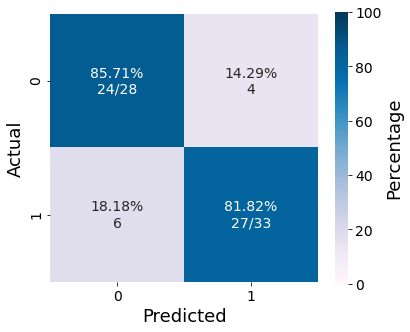

In [13]:
my_errors(model, X_test, y_test, skl_api = True)
cm_analysis(y_test, preds_class, model.classes_, ymap=None, figsize=(6,5))

### Using the `Pool` Function

We can use the `Pool` function to clean up our datasets. Notice right now that we have separate objects for X, y, and cat_features. <br>
Pool combines all of these (and more) into one object that you can plug into CatBoost.

Let's create pool objects for all our data sets (train, test, val)

In [14]:
for var in ['train','test']:
    globals()[var + '_pool'] = Pool(data = globals()['X_'+var],
                                    label = globals()['y_'+var],
                                    cat_features = cat_features)

Notice that we can run the same fit as the previous section, specifying one thing (the Pooled object) instead of three (X, y, and cat_features).

In [15]:
model = CatBoostClassifier(random_state = 1010)
model.fit(train_pool)

Learning rate set to 0.005621
0:	learn: 0.6902282	total: 32.8ms	remaining: 32.7s
1:	learn: 0.6856966	total: 59.9ms	remaining: 29.9s
2:	learn: 0.6817450	total: 81.1ms	remaining: 27s
3:	learn: 0.6786744	total: 101ms	remaining: 25.3s
4:	learn: 0.6748284	total: 127ms	remaining: 25.2s
5:	learn: 0.6713394	total: 142ms	remaining: 23.5s
6:	learn: 0.6671853	total: 151ms	remaining: 21.5s
7:	learn: 0.6635964	total: 168ms	remaining: 20.9s
8:	learn: 0.6604403	total: 176ms	remaining: 19.4s
9:	learn: 0.6572662	total: 186ms	remaining: 18.4s
10:	learn: 0.6554608	total: 188ms	remaining: 16.9s
11:	learn: 0.6517637	total: 206ms	remaining: 17s
12:	learn: 0.6482602	total: 215ms	remaining: 16.4s
13:	learn: 0.6449387	total: 230ms	remaining: 16.2s
14:	learn: 0.6414415	total: 245ms	remaining: 16.1s
15:	learn: 0.6384453	total: 262ms	remaining: 16.1s
16:	learn: 0.6354971	total: 269ms	remaining: 15.6s
17:	learn: 0.6316828	total: 282ms	remaining: 15.4s
18:	learn: 0.6291004	total: 310ms	remaining: 16s
19:	learn: 0.6

168:	learn: 0.3818863	total: 2.11s	remaining: 10.4s
169:	learn: 0.3810843	total: 2.12s	remaining: 10.4s
170:	learn: 0.3800785	total: 2.13s	remaining: 10.3s
171:	learn: 0.3789871	total: 2.15s	remaining: 10.3s
172:	learn: 0.3779926	total: 2.15s	remaining: 10.3s
173:	learn: 0.3769378	total: 2.17s	remaining: 10.3s
174:	learn: 0.3765625	total: 2.18s	remaining: 10.3s
175:	learn: 0.3760216	total: 2.19s	remaining: 10.3s
176:	learn: 0.3750140	total: 2.2s	remaining: 10.2s
177:	learn: 0.3741901	total: 2.21s	remaining: 10.2s
178:	learn: 0.3730202	total: 2.23s	remaining: 10.2s
179:	learn: 0.3720234	total: 2.23s	remaining: 10.2s
180:	learn: 0.3707705	total: 2.25s	remaining: 10.2s
181:	learn: 0.3697448	total: 2.25s	remaining: 10.1s
182:	learn: 0.3689860	total: 2.27s	remaining: 10.1s
183:	learn: 0.3681647	total: 2.28s	remaining: 10.1s
184:	learn: 0.3672041	total: 2.3s	remaining: 10.1s
185:	learn: 0.3663164	total: 2.32s	remaining: 10.1s
186:	learn: 0.3654393	total: 2.32s	remaining: 10.1s
187:	learn: 0.

336:	learn: 0.2814433	total: 4.24s	remaining: 8.34s
337:	learn: 0.2810289	total: 4.25s	remaining: 8.32s
338:	learn: 0.2807228	total: 4.27s	remaining: 8.32s
339:	learn: 0.2801074	total: 4.28s	remaining: 8.31s
340:	learn: 0.2798956	total: 4.3s	remaining: 8.3s
341:	learn: 0.2794624	total: 4.32s	remaining: 8.31s
342:	learn: 0.2790911	total: 4.34s	remaining: 8.31s
343:	learn: 0.2785090	total: 4.35s	remaining: 8.3s
344:	learn: 0.2781091	total: 4.38s	remaining: 8.31s
345:	learn: 0.2775586	total: 4.4s	remaining: 8.31s
346:	learn: 0.2770685	total: 4.41s	remaining: 8.3s
347:	learn: 0.2768328	total: 4.42s	remaining: 8.29s
348:	learn: 0.2765647	total: 4.45s	remaining: 8.29s
349:	learn: 0.2759995	total: 4.45s	remaining: 8.27s
350:	learn: 0.2756193	total: 4.46s	remaining: 8.25s
351:	learn: 0.2753724	total: 4.47s	remaining: 8.22s
352:	learn: 0.2751354	total: 4.48s	remaining: 8.21s
353:	learn: 0.2748207	total: 4.49s	remaining: 8.2s
354:	learn: 0.2743713	total: 4.51s	remaining: 8.19s
355:	learn: 0.2741

501:	learn: 0.2321012	total: 6.43s	remaining: 6.38s
502:	learn: 0.2320220	total: 6.43s	remaining: 6.35s
503:	learn: 0.2318971	total: 6.45s	remaining: 6.35s
504:	learn: 0.2318827	total: 6.46s	remaining: 6.33s
505:	learn: 0.2314853	total: 6.47s	remaining: 6.31s
506:	learn: 0.2313133	total: 6.48s	remaining: 6.3s
507:	learn: 0.2311325	total: 6.49s	remaining: 6.29s
508:	learn: 0.2311245	total: 6.5s	remaining: 6.27s
509:	learn: 0.2309926	total: 6.5s	remaining: 6.25s
510:	learn: 0.2304923	total: 6.51s	remaining: 6.23s
511:	learn: 0.2304399	total: 6.52s	remaining: 6.21s
512:	learn: 0.2300699	total: 6.53s	remaining: 6.2s
513:	learn: 0.2299305	total: 6.54s	remaining: 6.18s
514:	learn: 0.2298278	total: 6.54s	remaining: 6.16s
515:	learn: 0.2297288	total: 6.55s	remaining: 6.14s
516:	learn: 0.2296291	total: 6.56s	remaining: 6.13s
517:	learn: 0.2294729	total: 6.58s	remaining: 6.12s
518:	learn: 0.2294170	total: 6.59s	remaining: 6.11s
519:	learn: 0.2291981	total: 6.6s	remaining: 6.09s
520:	learn: 0.228

671:	learn: 0.1990951	total: 8.56s	remaining: 4.18s
672:	learn: 0.1989582	total: 8.57s	remaining: 4.16s
673:	learn: 0.1988265	total: 8.58s	remaining: 4.15s
674:	learn: 0.1986232	total: 8.6s	remaining: 4.14s
675:	learn: 0.1984978	total: 8.61s	remaining: 4.13s
676:	learn: 0.1981092	total: 8.63s	remaining: 4.12s
677:	learn: 0.1978845	total: 8.65s	remaining: 4.11s
678:	learn: 0.1977209	total: 8.66s	remaining: 4.09s
679:	learn: 0.1977135	total: 8.67s	remaining: 4.08s
680:	learn: 0.1975459	total: 8.69s	remaining: 4.07s
681:	learn: 0.1972244	total: 8.7s	remaining: 4.06s
682:	learn: 0.1969399	total: 8.72s	remaining: 4.05s
683:	learn: 0.1968986	total: 8.74s	remaining: 4.04s
684:	learn: 0.1966161	total: 8.76s	remaining: 4.03s
685:	learn: 0.1965003	total: 8.77s	remaining: 4.01s
686:	learn: 0.1963338	total: 8.78s	remaining: 4s
687:	learn: 0.1961885	total: 8.8s	remaining: 3.99s
688:	learn: 0.1961610	total: 8.82s	remaining: 3.98s
689:	learn: 0.1959500	total: 8.83s	remaining: 3.97s
690:	learn: 0.1957

833:	learn: 0.1732452	total: 10.7s	remaining: 2.13s
834:	learn: 0.1731909	total: 10.7s	remaining: 2.12s
835:	learn: 0.1731050	total: 10.7s	remaining: 2.1s
836:	learn: 0.1730204	total: 10.7s	remaining: 2.09s
837:	learn: 0.1728350	total: 10.8s	remaining: 2.08s
838:	learn: 0.1727486	total: 10.8s	remaining: 2.07s
839:	learn: 0.1726220	total: 10.8s	remaining: 2.05s
840:	learn: 0.1724354	total: 10.8s	remaining: 2.04s
841:	learn: 0.1722712	total: 10.8s	remaining: 2.03s
842:	learn: 0.1722037	total: 10.8s	remaining: 2.01s
843:	learn: 0.1721190	total: 10.8s	remaining: 2s
844:	learn: 0.1720381	total: 10.9s	remaining: 1.99s
845:	learn: 0.1718326	total: 10.9s	remaining: 1.98s
846:	learn: 0.1717285	total: 10.9s	remaining: 1.97s
847:	learn: 0.1716475	total: 10.9s	remaining: 1.95s
848:	learn: 0.1715278	total: 10.9s	remaining: 1.94s
849:	learn: 0.1714057	total: 10.9s	remaining: 1.93s
850:	learn: 0.1713059	total: 10.9s	remaining: 1.92s
851:	learn: 0.1712157	total: 11s	remaining: 1.9s
852:	learn: 0.17106

Average Precision Score: 0.8109706264121918
Balanced Accuracy Score: 0.8376623376623377


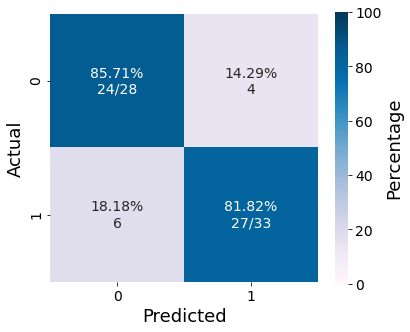

In [16]:
my_errors(model, X_test, y_test, skl_api = True)
cm_analysis(y_test, preds_class, model.classes_, ymap=None, figsize=(6,5))

### Other Tweaks: `eval_set`, `use_best_model`

We can also specify an evaluation set along with our training set. The param is `eval_set`, and takes an object created with `Pool`. We can also set `use_best_model` to `True`. This way, we'll use the best model we find during training based on the eval set.

Notice how in our plot, the Logloss of both the train and eval sets are shown.

In [17]:
model = CatBoostClassifier(random_state = 1010)
model.fit(train_pool,
          plot = True,
          use_best_model = True,
          eval_set = test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.022321
0:	learn: 0.6816855	test: 0.6842214	best: 0.6842214 (0)	total: 27.5ms	remaining: 27.5s
1:	learn: 0.6643439	test: 0.6691303	best: 0.6691303 (1)	total: 57.8ms	remaining: 28.8s
2:	learn: 0.6496366	test: 0.6573799	best: 0.6573799 (2)	total: 81.9ms	remaining: 27.2s
3:	learn: 0.6386803	test: 0.6476477	best: 0.6476477 (3)	total: 101ms	remaining: 25.1s
4:	learn: 0.6253133	test: 0.6334635	best: 0.6334635 (4)	total: 122ms	remaining: 24.3s
5:	learn: 0.6134714	test: 0.6228989	best: 0.6228989 (5)	total: 139ms	remaining: 23s
6:	learn: 0.5998214	test: 0.6091429	best: 0.6091429 (6)	total: 146ms	remaining: 20.7s
7:	learn: 0.5881020	test: 0.5971391	best: 0.5971391 (7)	total: 164ms	remaining: 20.3s
8:	learn: 0.5796155	test: 0.5902595	best: 0.5902595 (8)	total: 174ms	remaining: 19.1s
9:	learn: 0.5673246	test: 0.5796938	best: 0.5796938 (9)	total: 196ms	remaining: 19.4s
10:	learn: 0.5596961	test: 0.5702960	best: 0.5702960 (10)	total: 206ms	remaining: 18.5s
11:	learn: 0.5485661	

100:	learn: 0.2709690	test: 0.3348729	best: 0.3348729 (100)	total: 1.2s	remaining: 10.7s
101:	learn: 0.2684576	test: 0.3341909	best: 0.3341909 (101)	total: 1.23s	remaining: 10.8s
102:	learn: 0.2674777	test: 0.3327671	best: 0.3327671 (102)	total: 1.24s	remaining: 10.8s
103:	learn: 0.2663517	test: 0.3325821	best: 0.3325821 (103)	total: 1.26s	remaining: 10.9s
104:	learn: 0.2661230	test: 0.3320197	best: 0.3320197 (104)	total: 1.27s	remaining: 10.8s
105:	learn: 0.2648110	test: 0.3324363	best: 0.3320197 (104)	total: 1.28s	remaining: 10.8s
106:	learn: 0.2635351	test: 0.3319766	best: 0.3319766 (106)	total: 1.29s	remaining: 10.8s
107:	learn: 0.2622364	test: 0.3313805	best: 0.3313805 (107)	total: 1.31s	remaining: 10.8s
108:	learn: 0.2613734	test: 0.3309503	best: 0.3309503 (108)	total: 1.32s	remaining: 10.8s
109:	learn: 0.2599964	test: 0.3307675	best: 0.3307675 (109)	total: 1.34s	remaining: 10.9s
110:	learn: 0.2587956	test: 0.3288700	best: 0.3288700 (110)	total: 1.35s	remaining: 10.8s
111:	learn:

196:	learn: 0.1837918	test: 0.3222618	best: 0.3177524 (152)	total: 2.56s	remaining: 10.4s
197:	learn: 0.1836026	test: 0.3222692	best: 0.3177524 (152)	total: 2.57s	remaining: 10.4s
198:	learn: 0.1835132	test: 0.3223687	best: 0.3177524 (152)	total: 2.58s	remaining: 10.4s
199:	learn: 0.1830856	test: 0.3222319	best: 0.3177524 (152)	total: 2.59s	remaining: 10.3s
200:	learn: 0.1824681	test: 0.3219018	best: 0.3177524 (152)	total: 2.6s	remaining: 10.3s
201:	learn: 0.1820818	test: 0.3219350	best: 0.3177524 (152)	total: 2.6s	remaining: 10.3s
202:	learn: 0.1817722	test: 0.3226958	best: 0.3177524 (152)	total: 2.61s	remaining: 10.3s
203:	learn: 0.1815907	test: 0.3229505	best: 0.3177524 (152)	total: 2.62s	remaining: 10.2s
204:	learn: 0.1803265	test: 0.3229751	best: 0.3177524 (152)	total: 2.63s	remaining: 10.2s
205:	learn: 0.1789254	test: 0.3226986	best: 0.3177524 (152)	total: 2.65s	remaining: 10.2s
206:	learn: 0.1781138	test: 0.3227684	best: 0.3177524 (152)	total: 2.67s	remaining: 10.2s
207:	learn: 

292:	learn: 0.1348899	test: 0.3162760	best: 0.3154921 (290)	total: 3.82s	remaining: 9.22s
293:	learn: 0.1344974	test: 0.3165074	best: 0.3154921 (290)	total: 3.85s	remaining: 9.24s
294:	learn: 0.1341562	test: 0.3169324	best: 0.3154921 (290)	total: 3.87s	remaining: 9.26s
295:	learn: 0.1337994	test: 0.3169657	best: 0.3154921 (290)	total: 3.89s	remaining: 9.26s
296:	learn: 0.1335068	test: 0.3173292	best: 0.3154921 (290)	total: 3.91s	remaining: 9.26s
297:	learn: 0.1332726	test: 0.3171015	best: 0.3154921 (290)	total: 3.93s	remaining: 9.26s
298:	learn: 0.1331233	test: 0.3172620	best: 0.3154921 (290)	total: 3.95s	remaining: 9.26s
299:	learn: 0.1324702	test: 0.3171945	best: 0.3154921 (290)	total: 3.96s	remaining: 9.25s
300:	learn: 0.1319363	test: 0.3167356	best: 0.3154921 (290)	total: 3.98s	remaining: 9.24s
301:	learn: 0.1314097	test: 0.3170473	best: 0.3154921 (290)	total: 4s	remaining: 9.23s
302:	learn: 0.1308203	test: 0.3170403	best: 0.3154921 (290)	total: 4.01s	remaining: 9.22s
303:	learn: 0

387:	learn: 0.1000370	test: 0.3268814	best: 0.3154921 (290)	total: 5.36s	remaining: 8.46s
388:	learn: 0.0999166	test: 0.3267784	best: 0.3154921 (290)	total: 5.38s	remaining: 8.45s
389:	learn: 0.0996947	test: 0.3263154	best: 0.3154921 (290)	total: 5.39s	remaining: 8.43s
390:	learn: 0.0990342	test: 0.3260642	best: 0.3154921 (290)	total: 5.41s	remaining: 8.42s
391:	learn: 0.0984552	test: 0.3257602	best: 0.3154921 (290)	total: 5.42s	remaining: 8.4s
392:	learn: 0.0980491	test: 0.3251890	best: 0.3154921 (290)	total: 5.43s	remaining: 8.39s
393:	learn: 0.0978608	test: 0.3249403	best: 0.3154921 (290)	total: 5.45s	remaining: 8.38s
394:	learn: 0.0971139	test: 0.3251888	best: 0.3154921 (290)	total: 5.46s	remaining: 8.36s
395:	learn: 0.0967914	test: 0.3252035	best: 0.3154921 (290)	total: 5.48s	remaining: 8.35s
396:	learn: 0.0965634	test: 0.3257983	best: 0.3154921 (290)	total: 5.5s	remaining: 8.35s
397:	learn: 0.0963525	test: 0.3251708	best: 0.3154921 (290)	total: 5.51s	remaining: 8.33s
398:	learn: 

485:	learn: 0.0713386	test: 0.3235399	best: 0.3154921 (290)	total: 6.93s	remaining: 7.33s
486:	learn: 0.0710022	test: 0.3234016	best: 0.3154921 (290)	total: 6.94s	remaining: 7.31s
487:	learn: 0.0706918	test: 0.3236668	best: 0.3154921 (290)	total: 6.96s	remaining: 7.31s
488:	learn: 0.0704604	test: 0.3234230	best: 0.3154921 (290)	total: 6.98s	remaining: 7.29s
489:	learn: 0.0704446	test: 0.3234220	best: 0.3154921 (290)	total: 7.01s	remaining: 7.29s
490:	learn: 0.0701476	test: 0.3238651	best: 0.3154921 (290)	total: 7.03s	remaining: 7.29s
491:	learn: 0.0698835	test: 0.3243340	best: 0.3154921 (290)	total: 7.04s	remaining: 7.27s
492:	learn: 0.0698687	test: 0.3243325	best: 0.3154921 (290)	total: 7.05s	remaining: 7.25s
493:	learn: 0.0695499	test: 0.3238833	best: 0.3154921 (290)	total: 7.06s	remaining: 7.24s
494:	learn: 0.0695335	test: 0.3238703	best: 0.3154921 (290)	total: 7.07s	remaining: 7.21s
495:	learn: 0.0695163	test: 0.3238741	best: 0.3154921 (290)	total: 7.07s	remaining: 7.18s
496:	learn

581:	learn: 0.0552690	test: 0.3276486	best: 0.3154921 (290)	total: 8.28s	remaining: 5.95s
582:	learn: 0.0550388	test: 0.3270545	best: 0.3154921 (290)	total: 8.3s	remaining: 5.93s
583:	learn: 0.0549490	test: 0.3268082	best: 0.3154921 (290)	total: 8.32s	remaining: 5.92s
584:	learn: 0.0547924	test: 0.3261004	best: 0.3154921 (290)	total: 8.34s	remaining: 5.92s
585:	learn: 0.0547097	test: 0.3255526	best: 0.3154921 (290)	total: 8.36s	remaining: 5.91s
586:	learn: 0.0545284	test: 0.3261642	best: 0.3154921 (290)	total: 8.38s	remaining: 5.89s
587:	learn: 0.0543685	test: 0.3261588	best: 0.3154921 (290)	total: 8.39s	remaining: 5.88s
588:	learn: 0.0541830	test: 0.3264273	best: 0.3154921 (290)	total: 8.41s	remaining: 5.87s
589:	learn: 0.0540780	test: 0.3264389	best: 0.3154921 (290)	total: 8.42s	remaining: 5.85s
590:	learn: 0.0539559	test: 0.3266263	best: 0.3154921 (290)	total: 8.45s	remaining: 5.84s
591:	learn: 0.0538667	test: 0.3269330	best: 0.3154921 (290)	total: 8.46s	remaining: 5.83s
592:	learn:

676:	learn: 0.0443200	test: 0.3232035	best: 0.3154921 (290)	total: 9.61s	remaining: 4.58s
677:	learn: 0.0442432	test: 0.3233723	best: 0.3154921 (290)	total: 9.63s	remaining: 4.57s
678:	learn: 0.0440772	test: 0.3238835	best: 0.3154921 (290)	total: 9.64s	remaining: 4.56s
679:	learn: 0.0439596	test: 0.3243132	best: 0.3154921 (290)	total: 9.67s	remaining: 4.55s
680:	learn: 0.0438052	test: 0.3247119	best: 0.3154921 (290)	total: 9.68s	remaining: 4.53s
681:	learn: 0.0437408	test: 0.3244289	best: 0.3154921 (290)	total: 9.69s	remaining: 4.52s
682:	learn: 0.0435794	test: 0.3242488	best: 0.3154921 (290)	total: 9.7s	remaining: 4.5s
683:	learn: 0.0435040	test: 0.3242166	best: 0.3154921 (290)	total: 9.72s	remaining: 4.49s
684:	learn: 0.0434509	test: 0.3239340	best: 0.3154921 (290)	total: 9.74s	remaining: 4.48s
685:	learn: 0.0433954	test: 0.3238542	best: 0.3154921 (290)	total: 9.76s	remaining: 4.47s
686:	learn: 0.0433526	test: 0.3238568	best: 0.3154921 (290)	total: 9.78s	remaining: 4.45s
687:	learn: 

768:	learn: 0.0365835	test: 0.3323562	best: 0.3154921 (290)	total: 11s	remaining: 3.3s
769:	learn: 0.0365242	test: 0.3323273	best: 0.3154921 (290)	total: 11s	remaining: 3.29s
770:	learn: 0.0364487	test: 0.3327170	best: 0.3154921 (290)	total: 11s	remaining: 3.27s
771:	learn: 0.0364067	test: 0.3327494	best: 0.3154921 (290)	total: 11s	remaining: 3.26s
772:	learn: 0.0363309	test: 0.3326178	best: 0.3154921 (290)	total: 11s	remaining: 3.24s
773:	learn: 0.0363153	test: 0.3327074	best: 0.3154921 (290)	total: 11.1s	remaining: 3.23s
774:	learn: 0.0362570	test: 0.3329149	best: 0.3154921 (290)	total: 11.1s	remaining: 3.22s
775:	learn: 0.0361271	test: 0.3328792	best: 0.3154921 (290)	total: 11.1s	remaining: 3.21s
776:	learn: 0.0360498	test: 0.3334148	best: 0.3154921 (290)	total: 11.2s	remaining: 3.21s
777:	learn: 0.0359892	test: 0.3336669	best: 0.3154921 (290)	total: 11.2s	remaining: 3.2s
778:	learn: 0.0359436	test: 0.3338885	best: 0.3154921 (290)	total: 11.2s	remaining: 3.19s
779:	learn: 0.0358472	

862:	learn: 0.0306466	test: 0.3355318	best: 0.3154921 (290)	total: 12.8s	remaining: 2.03s
863:	learn: 0.0305678	test: 0.3355761	best: 0.3154921 (290)	total: 12.8s	remaining: 2.02s
864:	learn: 0.0304985	test: 0.3355595	best: 0.3154921 (290)	total: 12.8s	remaining: 2s
865:	learn: 0.0304289	test: 0.3352325	best: 0.3154921 (290)	total: 12.9s	remaining: 1.99s
866:	learn: 0.0303640	test: 0.3350704	best: 0.3154921 (290)	total: 12.9s	remaining: 1.97s
867:	learn: 0.0302923	test: 0.3353157	best: 0.3154921 (290)	total: 12.9s	remaining: 1.96s
868:	learn: 0.0302477	test: 0.3351601	best: 0.3154921 (290)	total: 12.9s	remaining: 1.94s
869:	learn: 0.0301746	test: 0.3351126	best: 0.3154921 (290)	total: 12.9s	remaining: 1.93s
870:	learn: 0.0300999	test: 0.3348981	best: 0.3154921 (290)	total: 12.9s	remaining: 1.91s
871:	learn: 0.0300200	test: 0.3348571	best: 0.3154921 (290)	total: 13s	remaining: 1.9s
872:	learn: 0.0299761	test: 0.3346921	best: 0.3154921 (290)	total: 13s	remaining: 1.89s
873:	learn: 0.0299

956:	learn: 0.0260228	test: 0.3364186	best: 0.3154921 (290)	total: 14.3s	remaining: 643ms
957:	learn: 0.0259924	test: 0.3365594	best: 0.3154921 (290)	total: 14.3s	remaining: 627ms
958:	learn: 0.0259486	test: 0.3367784	best: 0.3154921 (290)	total: 14.3s	remaining: 613ms
959:	learn: 0.0258951	test: 0.3370181	best: 0.3154921 (290)	total: 14.4s	remaining: 598ms
960:	learn: 0.0258358	test: 0.3369356	best: 0.3154921 (290)	total: 14.4s	remaining: 583ms
961:	learn: 0.0257888	test: 0.3366323	best: 0.3154921 (290)	total: 14.4s	remaining: 568ms
962:	learn: 0.0257361	test: 0.3369125	best: 0.3154921 (290)	total: 14.4s	remaining: 553ms
963:	learn: 0.0256600	test: 0.3375022	best: 0.3154921 (290)	total: 14.4s	remaining: 539ms
964:	learn: 0.0256056	test: 0.3375958	best: 0.3154921 (290)	total: 14.4s	remaining: 524ms
965:	learn: 0.0255522	test: 0.3376901	best: 0.3154921 (290)	total: 14.4s	remaining: 508ms
966:	learn: 0.0255374	test: 0.3375131	best: 0.3154921 (290)	total: 14.5s	remaining: 493ms
967:	learn

The model results changed because we are now using an additional evaluation set in training, even if we're using the same random seed. In this case the model **performed slightly better** (one less false positive). It's possible for the model to perform worse, but that depends on your parameters and your dataset.

In [18]:
probs, preds = my_errors(model, X_test, y_test, skl_api = True)
cm_analysis(y_test, preds, model.classes_, ymap=None, figsize=(6,5))

Average Precision Score: 0.8347242921013414
Balanced Accuracy Score: 0.8555194805194806


### CatBoost CV

CatBoost has its own built in cv function that you can use. Notice the arg placement: <br>
1. Pool object (train_dataset)
1. Parameter dictionary (params) - the parameters you'd normally place into `CatBoostClassifier`
1. Succeeding params are for the `cv` function <br>

Notice that you can also plot the CV results - a confidence interval will be displayed since you have multiple folds in your data.

In [19]:
params = {'loss_function':'Logloss'}

scores = cv(train_pool,
            params,
            fold_count = 5,
            plot = True,
            stratified = True,
            seed = 1010,
            )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6718697	test: 0.6780992	best: 0.6780992 (0)	total: 233ms	remaining: 3m 53s
1:	learn: 0.6539076	test: 0.6643677	best: 0.6643677 (1)	total: 381ms	remaining: 3m 10s
2:	learn: 0.6376537	test: 0.6506513	best: 0.6506513 (2)	total: 542ms	remaining: 3m
3:	learn: 0.6205454	test: 0.6374851	best: 0.6374851 (3)	total: 699ms	remaining: 2m 54s
4:	learn: 0.6044220	test: 0.6244026	best: 0.6244026 (4)	total: 845ms	remaining: 2m 48s
5:	learn: 0.5899925	test: 0.6126313	best: 0.6126313 (5)	total: 984ms	remaining: 2m 43s
6:	learn: 0.5733461	test: 0.6004528	best: 0.6004528 (6)	total: 1.18s	remaining: 2m 47s
7:	learn: 0.5584452	test: 0.5871889	best: 0.5871889 (7)	total: 1.36s	remaining: 2m 49s
8:	learn: 0.5462151	test: 0.5763664	best: 0.5763664 (8)	total: 1.49s	remaining: 2m 44s
9:	learn: 0.5350537	test: 0.5675751	best: 0.5675751 (9)	total: 1.64s	remaining: 2m 42s
10:	learn: 0.5226619	test: 0.5565372	best: 0.5565372 (10)	total: 1.76s	remaining: 2m 38s
11:	learn: 0.5139550	test: 0.5506131	best: 0.

93:	learn: 0.2167504	test: 0.4033398	best: 0.4033398 (93)	total: 14.2s	remaining: 2m 16s
94:	learn: 0.2154001	test: 0.4036234	best: 0.4033398 (93)	total: 14.3s	remaining: 2m 16s
95:	learn: 0.2140102	test: 0.4033457	best: 0.4033398 (93)	total: 14.5s	remaining: 2m 16s
96:	learn: 0.2128938	test: 0.4028129	best: 0.4028129 (96)	total: 14.6s	remaining: 2m 15s
97:	learn: 0.2113304	test: 0.4031501	best: 0.4028129 (96)	total: 14.8s	remaining: 2m 15s
98:	learn: 0.2103856	test: 0.4033153	best: 0.4028129 (96)	total: 14.9s	remaining: 2m 15s
99:	learn: 0.2093521	test: 0.4032259	best: 0.4028129 (96)	total: 15s	remaining: 2m 15s
100:	learn: 0.2080069	test: 0.4027855	best: 0.4027855 (100)	total: 15.2s	remaining: 2m 15s
101:	learn: 0.2063951	test: 0.4022036	best: 0.4022036 (101)	total: 15.3s	remaining: 2m 14s
102:	learn: 0.2051374	test: 0.4022651	best: 0.4022036 (101)	total: 15.5s	remaining: 2m 14s
103:	learn: 0.2039564	test: 0.4024012	best: 0.4022036 (101)	total: 15.6s	remaining: 2m 14s
104:	learn: 0.2

184:	learn: 0.1332854	test: 0.4150569	best: 0.4022036 (101)	total: 28.5s	remaining: 2m 5s
185:	learn: 0.1324441	test: 0.4152432	best: 0.4022036 (101)	total: 28.7s	remaining: 2m 5s
186:	learn: 0.1313500	test: 0.4152529	best: 0.4022036 (101)	total: 28.8s	remaining: 2m 5s
187:	learn: 0.1306501	test: 0.4152787	best: 0.4022036 (101)	total: 29s	remaining: 2m 5s
188:	learn: 0.1302117	test: 0.4153961	best: 0.4022036 (101)	total: 29.2s	remaining: 2m 5s
189:	learn: 0.1296638	test: 0.4156496	best: 0.4022036 (101)	total: 29.4s	remaining: 2m 5s
190:	learn: 0.1287522	test: 0.4162882	best: 0.4022036 (101)	total: 29.6s	remaining: 2m 5s
191:	learn: 0.1283265	test: 0.4167282	best: 0.4022036 (101)	total: 29.7s	remaining: 2m 4s
192:	learn: 0.1274731	test: 0.4170190	best: 0.4022036 (101)	total: 29.9s	remaining: 2m 4s
193:	learn: 0.1269539	test: 0.4174264	best: 0.4022036 (101)	total: 30s	remaining: 2m 4s
194:	learn: 0.1261331	test: 0.4179666	best: 0.4022036 (101)	total: 30.1s	remaining: 2m 4s
195:	learn: 0.

277:	learn: 0.0822326	test: 0.4324719	best: 0.4022036 (101)	total: 44.8s	remaining: 1m 56s
278:	learn: 0.0819239	test: 0.4321816	best: 0.4022036 (101)	total: 44.9s	remaining: 1m 56s
279:	learn: 0.0816872	test: 0.4321558	best: 0.4022036 (101)	total: 45.1s	remaining: 1m 55s
280:	learn: 0.0814302	test: 0.4322693	best: 0.4022036 (101)	total: 45.2s	remaining: 1m 55s
281:	learn: 0.0809575	test: 0.4323867	best: 0.4022036 (101)	total: 45.4s	remaining: 1m 55s
282:	learn: 0.0806479	test: 0.4324407	best: 0.4022036 (101)	total: 45.5s	remaining: 1m 55s
283:	learn: 0.0803432	test: 0.4326580	best: 0.4022036 (101)	total: 45.7s	remaining: 1m 55s
284:	learn: 0.0798394	test: 0.4330796	best: 0.4022036 (101)	total: 45.9s	remaining: 1m 55s
285:	learn: 0.0795541	test: 0.4334284	best: 0.4022036 (101)	total: 46.1s	remaining: 1m 55s
286:	learn: 0.0789937	test: 0.4337515	best: 0.4022036 (101)	total: 46.3s	remaining: 1m 55s
287:	learn: 0.0786771	test: 0.4339286	best: 0.4022036 (101)	total: 46.4s	remaining: 1m 54s

369:	learn: 0.0549833	test: 0.4495116	best: 0.4022036 (101)	total: 1m	remaining: 1m 42s
370:	learn: 0.0548320	test: 0.4499385	best: 0.4022036 (101)	total: 1m	remaining: 1m 42s
371:	learn: 0.0545671	test: 0.4502330	best: 0.4022036 (101)	total: 1m	remaining: 1m 42s
372:	learn: 0.0543607	test: 0.4505372	best: 0.4022036 (101)	total: 1m 1s	remaining: 1m 42s
373:	learn: 0.0541022	test: 0.4508711	best: 0.4022036 (101)	total: 1m 1s	remaining: 1m 42s
374:	learn: 0.0538598	test: 0.4515482	best: 0.4022036 (101)	total: 1m 1s	remaining: 1m 42s
375:	learn: 0.0537755	test: 0.4513663	best: 0.4022036 (101)	total: 1m 1s	remaining: 1m 42s
376:	learn: 0.0535237	test: 0.4513792	best: 0.4022036 (101)	total: 1m 1s	remaining: 1m 42s
377:	learn: 0.0534448	test: 0.4514811	best: 0.4022036 (101)	total: 1m 2s	remaining: 1m 42s
378:	learn: 0.0532158	test: 0.4518523	best: 0.4022036 (101)	total: 1m 2s	remaining: 1m 41s
379:	learn: 0.0529935	test: 0.4524324	best: 0.4022036 (101)	total: 1m 2s	remaining: 1m 41s
380:	lea

459:	learn: 0.0402747	test: 0.4678632	best: 0.4022036 (101)	total: 1m 15s	remaining: 1m 29s
460:	learn: 0.0401530	test: 0.4680367	best: 0.4022036 (101)	total: 1m 16s	remaining: 1m 29s
461:	learn: 0.0400168	test: 0.4679348	best: 0.4022036 (101)	total: 1m 16s	remaining: 1m 28s
462:	learn: 0.0399033	test: 0.4678932	best: 0.4022036 (101)	total: 1m 16s	remaining: 1m 28s
463:	learn: 0.0397782	test: 0.4681621	best: 0.4022036 (101)	total: 1m 16s	remaining: 1m 28s
464:	learn: 0.0396330	test: 0.4687854	best: 0.4022036 (101)	total: 1m 16s	remaining: 1m 28s
465:	learn: 0.0394974	test: 0.4690180	best: 0.4022036 (101)	total: 1m 16s	remaining: 1m 28s
466:	learn: 0.0393668	test: 0.4690755	best: 0.4022036 (101)	total: 1m 17s	remaining: 1m 27s
467:	learn: 0.0392707	test: 0.4693804	best: 0.4022036 (101)	total: 1m 17s	remaining: 1m 27s
468:	learn: 0.0391818	test: 0.4696591	best: 0.4022036 (101)	total: 1m 17s	remaining: 1m 27s
469:	learn: 0.0390780	test: 0.4701769	best: 0.4022036 (101)	total: 1m 17s	remain

549:	learn: 0.0312378	test: 0.4853113	best: 0.4022036 (101)	total: 1m 30s	remaining: 1m 14s
550:	learn: 0.0311491	test: 0.4857735	best: 0.4022036 (101)	total: 1m 31s	remaining: 1m 14s
551:	learn: 0.0310960	test: 0.4859147	best: 0.4022036 (101)	total: 1m 31s	remaining: 1m 14s
552:	learn: 0.0310315	test: 0.4862022	best: 0.4022036 (101)	total: 1m 31s	remaining: 1m 13s
553:	learn: 0.0309236	test: 0.4864596	best: 0.4022036 (101)	total: 1m 31s	remaining: 1m 13s
554:	learn: 0.0308510	test: 0.4865574	best: 0.4022036 (101)	total: 1m 31s	remaining: 1m 13s
555:	learn: 0.0307852	test: 0.4865585	best: 0.4022036 (101)	total: 1m 31s	remaining: 1m 13s
556:	learn: 0.0306902	test: 0.4868743	best: 0.4022036 (101)	total: 1m 31s	remaining: 1m 13s
557:	learn: 0.0306228	test: 0.4873645	best: 0.4022036 (101)	total: 1m 32s	remaining: 1m 12s
558:	learn: 0.0305514	test: 0.4872269	best: 0.4022036 (101)	total: 1m 32s	remaining: 1m 12s
559:	learn: 0.0304896	test: 0.4874177	best: 0.4022036 (101)	total: 1m 32s	remain

639:	learn: 0.0254240	test: 0.4965977	best: 0.4022036 (101)	total: 1m 45s	remaining: 59.3s
640:	learn: 0.0253838	test: 0.4967069	best: 0.4022036 (101)	total: 1m 46s	remaining: 59.4s
641:	learn: 0.0253338	test: 0.4970423	best: 0.4022036 (101)	total: 1m 46s	remaining: 59.2s
642:	learn: 0.0252701	test: 0.4974565	best: 0.4022036 (101)	total: 1m 46s	remaining: 59s
643:	learn: 0.0252066	test: 0.4977843	best: 0.4022036 (101)	total: 1m 46s	remaining: 58.8s
644:	learn: 0.0251837	test: 0.4979837	best: 0.4022036 (101)	total: 1m 46s	remaining: 58.7s
645:	learn: 0.0251350	test: 0.4979770	best: 0.4022036 (101)	total: 1m 46s	remaining: 58.5s
646:	learn: 0.0250807	test: 0.4980950	best: 0.4022036 (101)	total: 1m 46s	remaining: 58.4s
647:	learn: 0.0250299	test: 0.4981164	best: 0.4022036 (101)	total: 1m 47s	remaining: 58.2s
648:	learn: 0.0249587	test: 0.4983687	best: 0.4022036 (101)	total: 1m 47s	remaining: 58s
649:	learn: 0.0248981	test: 0.4983674	best: 0.4022036 (101)	total: 1m 47s	remaining: 57.8s
650

731:	learn: 0.0213610	test: 0.5110180	best: 0.4022036 (101)	total: 2m	remaining: 44s
732:	learn: 0.0213215	test: 0.5110765	best: 0.4022036 (101)	total: 2m	remaining: 43.9s
733:	learn: 0.0212903	test: 0.5111826	best: 0.4022036 (101)	total: 2m	remaining: 43.7s
734:	learn: 0.0212644	test: 0.5113033	best: 0.4022036 (101)	total: 2m	remaining: 43.6s
735:	learn: 0.0212204	test: 0.5113707	best: 0.4022036 (101)	total: 2m 1s	remaining: 43.4s
736:	learn: 0.0211808	test: 0.5112259	best: 0.4022036 (101)	total: 2m 1s	remaining: 43.3s
737:	learn: 0.0211624	test: 0.5112883	best: 0.4022036 (101)	total: 2m 1s	remaining: 43.1s
738:	learn: 0.0211190	test: 0.5112515	best: 0.4022036 (101)	total: 2m 1s	remaining: 42.9s
739:	learn: 0.0210650	test: 0.5113367	best: 0.4022036 (101)	total: 2m 1s	remaining: 42.7s
740:	learn: 0.0210128	test: 0.5115092	best: 0.4022036 (101)	total: 2m 1s	remaining: 42.6s
741:	learn: 0.0209775	test: 0.5117684	best: 0.4022036 (101)	total: 2m 2s	remaining: 42.4s
742:	learn: 0.0209454	te

823:	learn: 0.0181109	test: 0.5215815	best: 0.4022036 (101)	total: 2m 15s	remaining: 28.9s
824:	learn: 0.0180633	test: 0.5220010	best: 0.4022036 (101)	total: 2m 15s	remaining: 28.8s
825:	learn: 0.0180157	test: 0.5221130	best: 0.4022036 (101)	total: 2m 15s	remaining: 28.6s
826:	learn: 0.0179872	test: 0.5221680	best: 0.4022036 (101)	total: 2m 16s	remaining: 28.5s
827:	learn: 0.0179545	test: 0.5223037	best: 0.4022036 (101)	total: 2m 16s	remaining: 28.3s
828:	learn: 0.0179301	test: 0.5224237	best: 0.4022036 (101)	total: 2m 16s	remaining: 28.1s
829:	learn: 0.0178938	test: 0.5226557	best: 0.4022036 (101)	total: 2m 16s	remaining: 28s
830:	learn: 0.0178676	test: 0.5226773	best: 0.4022036 (101)	total: 2m 16s	remaining: 27.8s
831:	learn: 0.0178259	test: 0.5226476	best: 0.4022036 (101)	total: 2m 16s	remaining: 27.6s
832:	learn: 0.0177919	test: 0.5227041	best: 0.4022036 (101)	total: 2m 17s	remaining: 27.5s
833:	learn: 0.0177677	test: 0.5227494	best: 0.4022036 (101)	total: 2m 17s	remaining: 27.3s
8

915:	learn: 0.0154544	test: 0.5324236	best: 0.4022036 (101)	total: 2m 31s	remaining: 13.9s
916:	learn: 0.0154208	test: 0.5326914	best: 0.4022036 (101)	total: 2m 31s	remaining: 13.7s
917:	learn: 0.0153992	test: 0.5327989	best: 0.4022036 (101)	total: 2m 31s	remaining: 13.6s
918:	learn: 0.0153657	test: 0.5328913	best: 0.4022036 (101)	total: 2m 32s	remaining: 13.4s
919:	learn: 0.0153405	test: 0.5330812	best: 0.4022036 (101)	total: 2m 32s	remaining: 13.2s
920:	learn: 0.0153126	test: 0.5331511	best: 0.4022036 (101)	total: 2m 32s	remaining: 13.1s
921:	learn: 0.0152950	test: 0.5333065	best: 0.4022036 (101)	total: 2m 32s	remaining: 12.9s
922:	learn: 0.0152767	test: 0.5334488	best: 0.4022036 (101)	total: 2m 32s	remaining: 12.8s
923:	learn: 0.0152549	test: 0.5335094	best: 0.4022036 (101)	total: 2m 33s	remaining: 12.6s
924:	learn: 0.0152293	test: 0.5336286	best: 0.4022036 (101)	total: 2m 33s	remaining: 12.4s
925:	learn: 0.0152091	test: 0.5336231	best: 0.4022036 (101)	total: 2m 33s	remaining: 12.3s

### Parameter Tuning

Let's tune parameters to improve our model further. 

The docs name the following as model parameters that might need tuning: <br>
- `iterations`
- `learning_rate`
- `depth` \- tree depth
- `one_hot_max_size` \- perform one hot encoding if categores $\leq$ `one_hot_max_size`.
- `l2_leaf_reg` \- coefficient of L2 regularization term, positive number
- `random_strength` \- use to avoid overfitting, the amount of randomness in scoring splits
- `bagging_temperature` \- [0,inf). For bayesian bootstrap.

Some other parameters:
- `od_type` \- to detect overfitting; either `IncToDec` or `Iter`

Here's the link for more details: https://catboost.ai/docs/concepts/parameter-tuning.html

Let's define a dict with parameter distributions (using scipy.stats). <br>

In [20]:
grid = {'learning_rate': stats.uniform(0.03,0.47),
        'depth': stats.randint(4,10),
        'l2_leaf_reg': stats.uniform(1,9),
        'one_hot_max_size': stats.randint(2,6),
        'random_strength': stats.uniform(0,10),
        'bagging_temperature': stats.uniform(0,10)}

We then use the built-in randomized search of CatBoostClassifier (`.randomized_search`). Note that after running this, `model` **will be ready for use** with the best parameters found (i.e. no need to fit again with the optimum parameters)! <br> <br>
Here are some important parameters for the `randomized_search` function: <br>
- `param_distributions` - a dict of parameter distributions; each distribution should either be a list or a scipy stats distribution
- `X` - the training dataset (`Pool` object - if it's not a Pool object, you have to specify `y` also)
- `cv` - number of folds to use in the cv (n-1 folds for training, and 1 fold for testing)
- `n_iter` - number of iterations for the random search
- `partition_random_seed` - the seed for the random permutations of the data; set a value for this if you want your random search to be reproducible
- `search_by_train_test_split` - recommended as `True` for large datasets and `False` for small ones; if `True`, model is trained on train set and  parameters are compared via the test set <br>

*Notes:* <br>
- *we also set the random seed in np so that drawing from our distributions is reproducible* <br>
- *we set `search_by_train_test_split = True` even if the recommended is `False`, because it **takes very long to run** when `False`*

In [21]:
model = CatBoostClassifier(random_state = 1010) #we need a model that has not been fitted
np.random.seed(seed=1010)
randomized_search_result = model.randomized_search(param_distributions = grid,
                                                   X=train_pool,
                                                   cv=5,
                                                   n_iter=100,
                                                   partition_random_seed=1010,
                                                   search_by_train_test_split=True,
                                                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.3233986	best: 0.3233986 (0)	total: 14.3s	remaining: 23m 38s
1:	loss: 0.3392508	best: 0.3233986 (0)	total: 18s	remaining: 14m 42s
2:	loss: 0.3154507	best: 0.3154507 (2)	total: 19.5s	remaining: 10m 29s
3:	loss: 0.3267094	best: 0.3154507 (2)	total: 38.1s	remaining: 15m 14s
4:	loss: 0.3401926	best: 0.3154507 (2)	total: 51s	remaining: 16m 9s
5:	loss: 0.3904133	best: 0.3154507 (2)	total: 52.3s	remaining: 13m 39s
6:	loss: 0.3566296	best: 0.3154507 (2)	total: 1m 8s	remaining: 15m 13s
7:	loss: 0.3176377	best: 0.3154507 (2)	total: 1m 25s	remaining: 16m 17s
8:	loss: 0.3381249	best: 0.3154507 (2)	total: 1m 43s	remaining: 17m 21s
9:	loss: 0.3672242	best: 0.3154507 (2)	total: 1m 44s	remaining: 15m 42s
10:	loss: 0.3822064	best: 0.3154507 (2)	total: 2m 14s	remaining: 18m 11s
11:	loss: 0.3858136	best: 0.3154507 (2)	total: 2m 17s	remaining: 16m 46s
12:	loss: 0.3843420	best: 0.3154507 (2)	total: 2m 18s	remaining: 15m 28s
13:	loss: 0.2910603	best: 0.2910603 (13)	total: 2m 46s	remaining: 17m 3s


We can look at the model params with `get_params()`

In [22]:
model.get_params()

{'random_state': 1010,
 'bagging_temperature': 1.7901291717351375,
 'random_strength': 2.2923825925049677,
 'depth': 5.0,
 'one_hot_max_size': 2.0,
 'learning_rate': 0.35204250884248744,
 'l2_leaf_reg': 1.0542193946184995}

Our balanced accuracy improved by a bit! And it took less than 20 minutes (you decide if that's worth it). However, for some random seeds default CatBoost could still outperform our tuned model. You should increase `n_iter` or get a larger dataset if you want the results to be more stable.

Average Precision Score: 0.8463558299623873
Balanced Accuracy Score: 0.8582251082251082


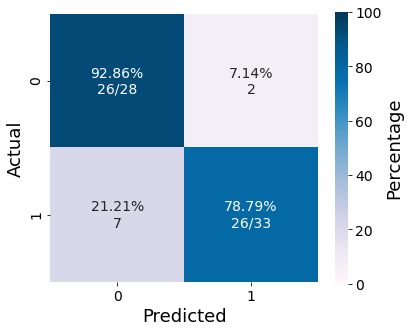

In [23]:
probs, preds = my_errors(model, X_test, y_test, skl_api = True)
cm_analysis(y_test, preds, model.classes_, ymap=None, figsize=(6,5))

### Feature Importances

Now that you have a trained model with tuned parameters, it's time to interpret the model with feature importances.

You have to install `shap` to plot the shap values from CatBoost. <br>
> `pip install shap`
in anaconda prompt <br>

Then run these lines below to import and initiate shap.

In [24]:
import shap
shap.initjs()

There's just one function to access the different feature importance metrics from CatBoost: <br>
**`get_feature_importance`**

You specify the metric type with `type = _`. Usually you set this to `FeatureImportance` so it's dynamic depending on the problem. <br><br>
I would split the options of this param into two types: (1) basic and (2) advanced.

**Basic** - usual values you'd expect from feature importance
1. `'PredictionValuesChange'` <br>
> Default for non-ranking metrics. Shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.
2. `'LossFunctionChange'`
>Default for ranking metrics. For each feature the value represents the difference between the loss value of the model with this feature and without it. Approximate only (values are dataset-dependent)
3. `'FeatureImportance'`<br>
> PredictionValuesChange for non-ranking metrics and LossFunctionChange for ranking metrics <br>

**Advanced** - more advanced feature analysis (recommended)
4. `'ShapValues'` <br>
> Get SHAP Values for every feature. Generates a vector  with contributions of each feature to the prediction for every input object and the expected value of the model prediction for the object (average prediction given no knowledge about the object).
5. `'Interaction'` <br>
> Get pairwise interaction strengths between features.

**Summary**<br>
In case you must apply this right away, set `type = 'FeatureImportance` to get regular feature importances. <br>
If you want to see how each data point affects the model, use `type = 'ShapValues'`

#### Basic Feature Importance

Let's look at typical feature importances (how we know them). We can set `prettified = True` to get a pandas df instead of a numpy array.

In [25]:
fi_values = model.get_feature_importance(train_pool, type = "FeatureImportance", prettified = True)
fi_values

Feature Id  Importances
0        thal    12.906382
1          ca    12.610759
2     oldpeak    10.874527
3       slope    10.193008
4          cp     9.590038
5         age     9.460423
6     thalach     8.914464
7        chol     7.047519
8     restecg     6.956936
9    trestbps     6.260252
10        sex     4.009231
11      exang     0.785320
12        fbs     0.391141

We see that the two most important features are `thal` (categorical; result of a blood flow test using thallium) and `ca` (int; number of major vessels colored by flouroscopy)

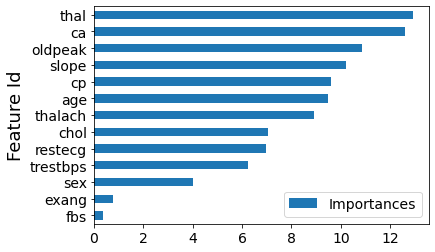

In [26]:
fi_values.set_index('Feature Id').plot.barh()
plt.gca().invert_yaxis()

#### Advanced Feature Importance (SHAP)

SHAP values are **contributions** of **each feature** to **each prediction instance**.

Let's get the SHAP values! Place `type = 'ShapValues'` in `get_feature_importance`. <br>
This site helped me a lot in understanding shap - https://christophm.github.io/interpretable-ml-book/shap.html

In [27]:
shap_values = model.get_feature_importance(train_pool, type = "ShapValues")

We must separate the actual SHAP values from the baseline value (which is just one value for all rows in your data). This is sort of like the base_score in XGBoost. That's why we take `shap_values[0,-1]` for the base_value, but you could specify any other row (e.g. `shap_values[1,-1]`) since all values in column -1 are the same.

In [28]:
base_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

#### Force Plot

The following is a force plot, which visualizes how **feature values** either **increase or decrease the prediction** from baseline. Each row in your training set will have a spot in the x-axis. Notice that the **plot is interactive**; you can change the ordering of the x-axis or specify which features you'd like to see.<br>
You can create the force plot with `shap.force_plot`, with the following inputs: <br>
> `base_value` - the baseline prediction value of your model <br>
> `shap_values` - the SHAP values (be sure to run the cell above to extract them) <br>
> `features` - we place in X_train so that the force plot can identify the features of your model (adds to the interactivity). If you leave this blank, you have less things you can access in the plot but it will still work.

In [29]:
shap.force_plot(base_value, shap_values, features = X_train)

#### Dependence Plot

Next is a dependence plot (`shap.dependence_plot`), which shows how values of a **specific feature** (in this example, `age`) affects your SHAP values. Note that the bar on the right (and the dot colors) visualize the **interaction** with another feature. By default it chooses the feature with the strongest interactions.

In [30]:
shap.dependence_plot("oldpeak",shap_values,X_train,interaction_index = 'thalach')

You can examine another feature's interactions with `age` using `interaction_index`, for example `interaction_index = 'cp'`. Notice how `thalach` was replaced by `cp`.<br>

In [31]:
shap.dependence_plot("age",shap_values,X_train,interaction_index = 'cp')

#### Summary Plot

This last plot is probably the **most informative at first glance**, and says **how high/low-valued inputs affect our model output**. We also get a sense of how the SHAP values are distributed per feature.

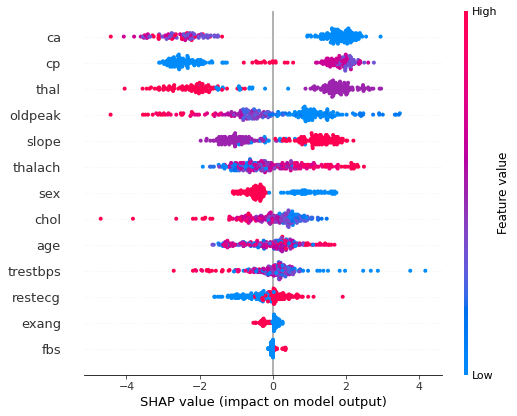

In [32]:
shap.summary_plot(shap_values, X_train)

#### Interactions

Finally, let's look at feature interactions. This is already built into CatBoost.

Below, I make a dictionary mapping numeric column indices to their corresponding names.

In [33]:
col_dict = dict(enumerate(X.columns))

Place `type = 'Interaction'` in `get_feature_importance` to generate a df of interaction values with the structure below (also make sure `prettified = True` to get a df).

In [34]:
df_interaction = model.get_feature_importance(train_pool, type = "Interaction", prettified = True)
df_interaction.head()

First Feature Index  Second Feature Index  Interaction
0                    2                    10     6.400393
1                    6                    10     4.581442
2                    2                    12     4.234823
3                    2                     6     3.063478
4                    9                    12     2.905883

We now make an upper diagonal matrix with the index and columns ordered the same way as X. We see the interaction values between each pair of features. There are **some features that do not have any interaction values**, the ones that were one hot encoded (based on the value of `one_hot_max_size`).

In [35]:
df_interaction.replace(col_dict).pivot_table(index = 'First Feature Index',columns = 'Second Feature Index', values = 'Interaction').reindex(col_dict.values()).loc[:,col_dict.values()]

Second Feature Index  age  sex        cp  trestbps      chol  fbs   restecg  \
First Feature Index                                                           
age                   NaN  NaN  0.945353  1.323679  0.806776  NaN  1.770243   
sex                   NaN  NaN       NaN       NaN       NaN  NaN       NaN   
cp                    NaN  NaN       NaN  1.929074  1.531097  NaN  3.063478   
trestbps              NaN  NaN       NaN       NaN  2.135021  NaN  1.864926   
chol                  NaN  NaN       NaN       NaN       NaN  NaN  1.999664   
fbs                   NaN  NaN       NaN       NaN       NaN  NaN       NaN   
restecg               NaN  NaN       NaN       NaN       NaN  NaN       NaN   
thalach               NaN  NaN       NaN       NaN       NaN  NaN       NaN   
exang                 NaN  NaN       NaN       NaN       NaN  NaN       NaN   
oldpeak               NaN  NaN       NaN       NaN       NaN  NaN       NaN   
slope                 NaN  NaN       NaN       NaN       NaN  NaN       NaN   
ca                    NaN  NaN       NaN       NaN       NaN  NaN       NaN   
thal                  NaN  NaN       NaN       NaN       NaN  NaN       NaN   

Second Feature Index   thalach  exang   oldpeak     slope        ca      thal  
First Feature Index                                                            
age                   1.932933    NaN  0.856903  1.784113  0.938005  2.731374  
sex                        NaN    NaN       NaN       NaN       NaN       NaN  
cp                    1.900140    NaN  2.008623  6.400393  1.454790  4.234823  
trestbps              1.338329    NaN  1.895498  2.600955  1.617970  2.835459  
chol                  1.258927    NaN  1.667704  2.123334  0.891593  1.761059  
fbs                        NaN    NaN       NaN       NaN       NaN       NaN  
restecg               1.060757    NaN  0.661670  4.581442  2.557499  2.701153  
thalach                    NaN    NaN  1.457437  1.196135  1.743057  2.077485  
exang                      NaN    NaN       NaN       NaN       NaN       NaN  
oldpeak                    NaN    NaN       NaN  1.749863  0.342843  2.905883  
slope                      NaN    NaN       NaN       NaN  0.960601  2.508316  
ca                         NaN    NaN       NaN       NaN       NaN  2.260670  
thal                       NaN    NaN       NaN       NaN       NaN       NaN

### Converting SHAP to Probability

We have to use `shap.TreeExplainer` to generate probabilities since the shap values from CatBoost are only in terms of raw model output (i.e. log odds). Converting from log odds to probability is not as simple as placing the SHAP values in the logistic function.<br><br>
We have to refit our model using the best parameters from random search and using the raw X_train so that it's compatible with this. Using a model with `cat_features` does not work with `TreeExplainer` for now.

In [36]:
mod = CatBoostClassifier(**model.get_params())
mod.fit(X_train, y_train)

0:	learn: 0.5120870	total: 1.58ms	remaining: 1.58s
1:	learn: 0.4539682	total: 2.67ms	remaining: 1.33s
2:	learn: 0.3971555	total: 4.01ms	remaining: 1.33s
3:	learn: 0.3518092	total: 5.2ms	remaining: 1.29s
4:	learn: 0.3121319	total: 6.31ms	remaining: 1.25s
5:	learn: 0.2764175	total: 7.31ms	remaining: 1.21s
6:	learn: 0.2693764	total: 8.51ms	remaining: 1.21s
7:	learn: 0.2366075	total: 9.83ms	remaining: 1.22s
8:	learn: 0.2329089	total: 10.9ms	remaining: 1.2s
9:	learn: 0.2169428	total: 12ms	remaining: 1.19s
10:	learn: 0.2028992	total: 13.2ms	remaining: 1.19s
11:	learn: 0.1931422	total: 14.3ms	remaining: 1.18s
12:	learn: 0.1817727	total: 15.6ms	remaining: 1.18s
13:	learn: 0.1743577	total: 16.5ms	remaining: 1.16s
14:	learn: 0.1667803	total: 17.6ms	remaining: 1.15s
15:	learn: 0.1600877	total: 18.6ms	remaining: 1.14s
16:	learn: 0.1541590	total: 19.9ms	remaining: 1.15s
17:	learn: 0.1422327	total: 21.1ms	remaining: 1.15s
18:	learn: 0.1313848	total: 22.6ms	remaining: 1.17s
19:	learn: 0.1139525	total

260:	learn: 0.0026140	total: 290ms	remaining: 821ms
261:	learn: 0.0026139	total: 291ms	remaining: 820ms
262:	learn: 0.0026138	total: 292ms	remaining: 818ms
263:	learn: 0.0026138	total: 293ms	remaining: 817ms
264:	learn: 0.0026134	total: 294ms	remaining: 815ms
265:	learn: 0.0026131	total: 295ms	remaining: 814ms
266:	learn: 0.0026130	total: 296ms	remaining: 812ms
267:	learn: 0.0026130	total: 297ms	remaining: 811ms
268:	learn: 0.0026130	total: 298ms	remaining: 810ms
269:	learn: 0.0026130	total: 299ms	remaining: 810ms
270:	learn: 0.0026129	total: 301ms	remaining: 809ms
271:	learn: 0.0026128	total: 302ms	remaining: 807ms
272:	learn: 0.0026127	total: 303ms	remaining: 806ms
273:	learn: 0.0026127	total: 304ms	remaining: 804ms
274:	learn: 0.0026126	total: 305ms	remaining: 803ms
275:	learn: 0.0026125	total: 305ms	remaining: 801ms
276:	learn: 0.0026124	total: 306ms	remaining: 800ms
277:	learn: 0.0026123	total: 307ms	remaining: 798ms
278:	learn: 0.0026121	total: 308ms	remaining: 797ms
279:	learn: 

560:	learn: 0.0023192	total: 593ms	remaining: 464ms
561:	learn: 0.0023192	total: 594ms	remaining: 463ms
562:	learn: 0.0023191	total: 595ms	remaining: 462ms
563:	learn: 0.0023189	total: 596ms	remaining: 461ms
564:	learn: 0.0023187	total: 597ms	remaining: 459ms
565:	learn: 0.0023187	total: 598ms	remaining: 458ms
566:	learn: 0.0023186	total: 599ms	remaining: 457ms
567:	learn: 0.0023185	total: 600ms	remaining: 456ms
568:	learn: 0.0023185	total: 601ms	remaining: 455ms
569:	learn: 0.0023181	total: 602ms	remaining: 454ms
570:	learn: 0.0023180	total: 602ms	remaining: 453ms
571:	learn: 0.0023179	total: 603ms	remaining: 452ms
572:	learn: 0.0023178	total: 604ms	remaining: 450ms
573:	learn: 0.0023177	total: 605ms	remaining: 449ms
574:	learn: 0.0023176	total: 606ms	remaining: 448ms
575:	learn: 0.0023176	total: 608ms	remaining: 447ms
576:	learn: 0.0023078	total: 608ms	remaining: 446ms
577:	learn: 0.0023078	total: 609ms	remaining: 445ms
578:	learn: 0.0023077	total: 610ms	remaining: 444ms
579:	learn: 

852:	learn: 0.0020496	total: 892ms	remaining: 154ms
853:	learn: 0.0020496	total: 893ms	remaining: 153ms
854:	learn: 0.0020496	total: 894ms	remaining: 152ms
855:	learn: 0.0020425	total: 895ms	remaining: 151ms
856:	learn: 0.0020425	total: 896ms	remaining: 150ms
857:	learn: 0.0020424	total: 897ms	remaining: 148ms
858:	learn: 0.0020424	total: 898ms	remaining: 147ms
859:	learn: 0.0020423	total: 899ms	remaining: 146ms
860:	learn: 0.0020423	total: 900ms	remaining: 145ms
861:	learn: 0.0020422	total: 901ms	remaining: 144ms
862:	learn: 0.0020422	total: 902ms	remaining: 143ms
863:	learn: 0.0020422	total: 903ms	remaining: 142ms
864:	learn: 0.0020421	total: 904ms	remaining: 141ms
865:	learn: 0.0020421	total: 905ms	remaining: 140ms
866:	learn: 0.0020421	total: 906ms	remaining: 139ms
867:	learn: 0.0020420	total: 907ms	remaining: 138ms
868:	learn: 0.0020241	total: 908ms	remaining: 137ms
869:	learn: 0.0020241	total: 909ms	remaining: 136ms
870:	learn: 0.0020241	total: 910ms	remaining: 135ms
871:	learn: 

In [37]:
explainer = shap.TreeExplainer(mod,
                               model_output = "probability",
                               data = X_train,
                               feature_perturbation = "interventional",
                               feature_dependence = "independent"
                              )
shap_probs = explainer.shap_values(X_train)

 98%|===================| 237/242 [00:18<00:00]        

Store shap values (in probability) in a dataframe

In [38]:
df_shap = pd.DataFrame(shap_probs)
df_shap.columns = X.columns
df_shap.head()

age       sex        cp  trestbps      chol       fbs   restecg  \
0  0.049561 -0.008885  0.050400  0.030698  0.038724 -0.001507 -0.011261   
1  0.049873  0.065353  0.068846  0.018908  0.018096  0.001538 -0.000998   
2  0.050664 -0.007626  0.088808  0.026408  0.026209 -0.000773  0.037450   
3  0.026654 -0.005714 -0.016030  0.002702  0.044382  0.001023  0.015255   
4  0.002739  0.067793 -0.017107  0.163667  0.003948  0.004315  0.002943   

    thalach     exang   oldpeak     slope        ca      thal  
0  0.062244  0.017381  0.069501  0.051952  0.115834 -0.010938  
1  0.047220  0.018944  0.010030 -0.025481  0.125968  0.055037  
2  0.023828  0.014323  0.081528  0.053862  0.004750  0.054121  
3  0.036735  0.019311  0.188344 -0.011145  0.089360  0.062240  
4 -0.004939  0.010129  0.035646 -0.011890  0.101914  0.093062

Plot marginal effects of some variables

In [39]:
def plot_marginal(col, reg = True):
    plt.subplots(figsize = (10,7))
    sns.regplot(X_train[col], df_shap[col], scatter_kws = {'s':50}, line_kws = {'color':'red'}, marker = '+', fit_reg = reg, order = 1, x_jitter = 0.05, y_jitter = 0.003)
    plt.title('Marginal effect of ' + col)
    plt.xlabel(col, size = 14)
    plt.ylabel('Effect on Predicted Probability\n  of No Heart Disease', size = 14)
    plt.ylim(-0.5, 0.5)
    plt.show()

In [40]:
plot_marginal('oldpeak')

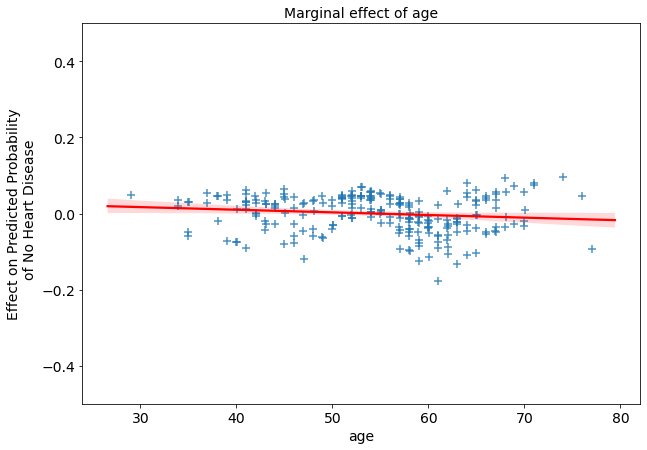

In [41]:
plot_marginal('age')

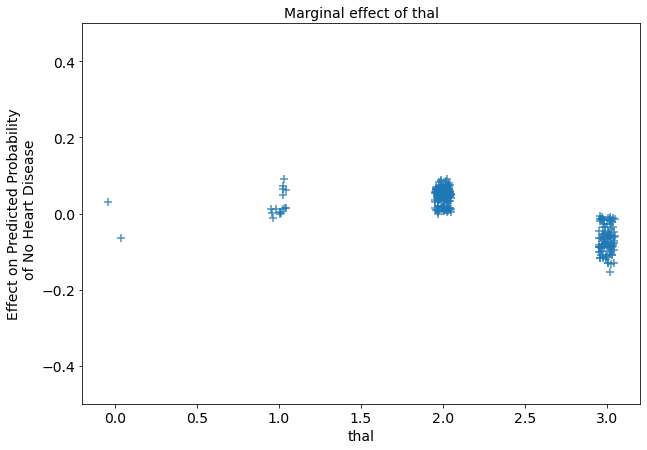

In [42]:
plot_marginal('thal', False)

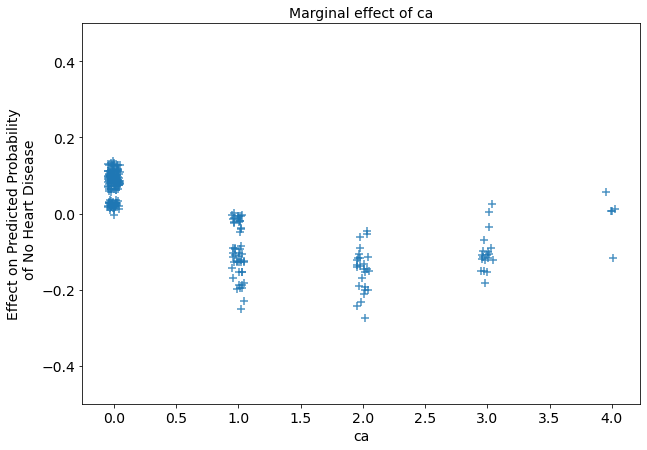

In [43]:
plot_marginal('ca', False)

## END

That's it for this tutorial! Hope you learned something ☺. Feel free to reach out in case you have any more questions, my email is `ponglao@savvysherpa.com`.